## How to Chunk Audio

How to chunk the audio stream into words, so that they can be processed independently without having cuts in the output?

In [2]:
import numpy as np
import torchaudio
import torch
import librosa
from IPython.display import display, Audio
from matplotlib import pyplot as plt

from stream_processing.models.knnvc.knnvc import rms

In [42]:
audiofile = "/Users/cafr02/datasets/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac"
audio = torchaudio.load(audiofile)[0].squeeze()
sample_rate = 16000
print(audio.shape)
display(Audio(audio.numpy(), rate=16000))

torch.Size([93680])


torch.Size([179])


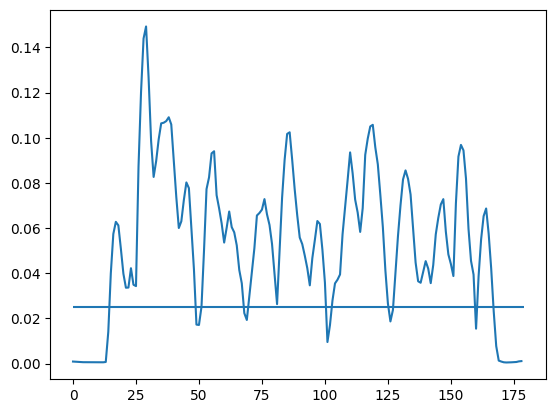

In [45]:
frame_len = 2048
hop_len = 512
threshold = 0.025
silent_frames = 5

va = rms(audio, frame_len, hop_len)
print(va.shape)
plt.plot(va)
plt.hlines(threshold, 0, len(va))
plt.show()

# split the audio into chunks, separated by silence
current_chunk = list()
current_silence = 0
for rms_idx, rms_val in enumerate(va):
    if rms_val > threshold:
        audio_chunk = audio[rms_idx * hop_len: (rms_idx + 1) * hop_len]
        current_chunk.append(audio_chunk)
    else:
        current_silence += 1
        if current_silence > silent_frames:
            if len(current_chunk) > 0:
                display(Audio(torch.cat(current_chunk).numpy(), rate=16000))
                current_chunk = []
            current_silence = 0

There is no way to avoid splitting on "t" sounds and alike. At least with this method

## Silero's VAD model

In [37]:
model, _ = torch.hub.load(
    repo_or_dir='snakers4/silero-vad',
    model='silero_vad',
    force_reload=True,
)

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /Users/cafr02/.cache/torch/hub/master.zip


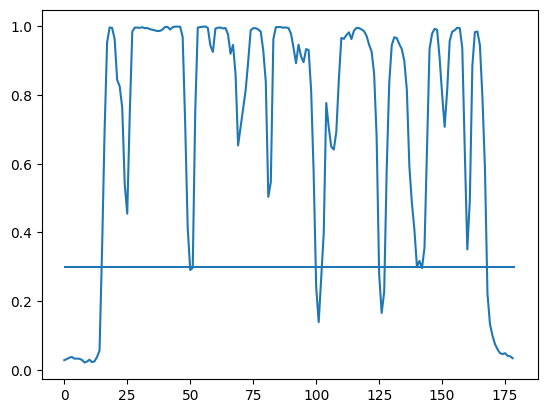

In [55]:
threshold = 0.3
silent_frames = 1

frames = audio.unfold(0, frame_len, hop_len)
vad_out = list()
for frame in frames:
    vad_out.append(model(frame, sample_rate)[0, 0])

plt.plot(vad_out)
plt.hlines(threshold, 0, len(vad_out))
plt.show()

# split the audio into chunks, separated by silence
current_chunk = list()
current_silence = 0
for rms_idx, rms_val in enumerate(vad_out):
    if rms_val > threshold:
        audio_chunk = audio[rms_idx * hop_len: (rms_idx + 1) * hop_len]
        current_chunk.append(audio_chunk)
    else:
        current_silence += 1
        if current_silence > silent_frames:
            if len(current_chunk) > 0:
                display(Audio(torch.cat(current_chunk).numpy(), rate=16000))
                current_chunk = []
            current_silence = 0

Silero's VAD also splits at plosive consonants.

torch.Size([934, 300])